In [1]:
pip install seaborn spacy catboost xgboost

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\yemia\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
import spacy
!python -m spacy download en_core_web_sm
import pandas as pd
import seaborn as sns
import gensim
import gensim.downloader as api
import re
import numpy as np
from sklearn.model_selection import train_test_split

     ---------------------------------------- 12.8/12.8 MB 5.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


You should consider upgrading via the 'C:\Users\yemia\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [3]:
# Models Libraries
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

# Evaluation Metric Libraries
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [4]:
# Load the data
data = pd.read_csv('sent_train.csv')
data.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


# Exploratory Data Analysis

<Axes: xlabel='label', ylabel='count'>

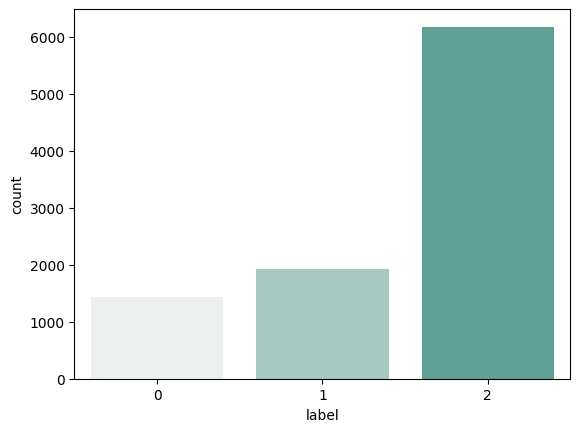

In [5]:

sns.countplot(data=data, x='label', palette='light:#5A9')

In [6]:
data['label'].value_counts()

label
2    6178
1    1923
0    1442
Name: count, dtype: int64

From the graph above we can see that the data is not balanced. the label 2 has 3 times as much data samples as 0 and 1 
So, we have a total of 9543 records, broken down as follows:

2(Neutral)     6178
1(Positive)    1923
0(Negative)    1442

This dataset would benefit from a rebalancing to make each class of sentiment have roughly the same number of samples

In order to do this, we would make the reduce both the Number of neutral sentiments and that of positive sentiment to be about 1500, each. Bringing the distribution of data to 
2(Neutral)     1500
1(Positive)    1500
0(Negative)    1442
Total          4442

label
1    1500
2    1500
0    1442
Name: count, dtype: int64

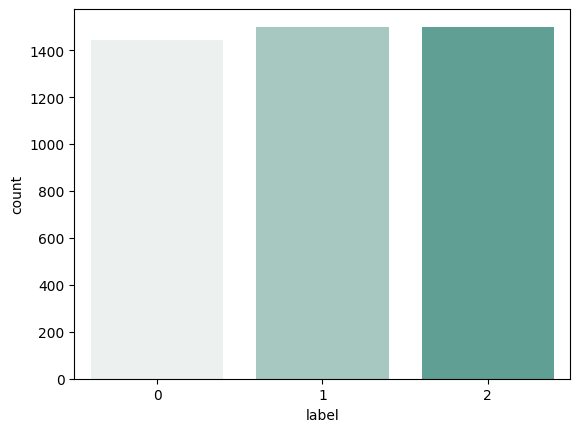

In [7]:
# Separate data for each label
label_0_data = data[data['label'] == 0]
label_1_data = data[data['label'] == 1].sample(n=1500, random_state=42)
label_2_data = data[data['label'] == 2].sample(n=1500, random_state=42)

# Concatenate the balanced data
balanced_data = pd.concat([label_0_data, label_1_data, label_2_data])

# Shuffle the balanced data
balanced_data = balanced_data.sample(frac=1, random_state=42)

sns.countplot(data=balanced_data, x='label', palette='light:#5A9')
balanced_data['label'].value_counts()

# Feature Engineering 
The data has now been balanced. 

In [8]:
# Using Spacy to delete stop_words
nlp = spacy.load('en_core_web_sm')
stop_words=nlp.Defaults.stop_words

Below i will write a preprocessing function that i will use in preproccessing the text data to make it suitable for NLP. The funciton will remove urls, special characters, and numbers from the text. it will perform lemmatization, and convert the text to tokens. 

In [9]:
# Load the English language model
nlp = spacy.load('en_core_web_sm')

# Your DataFrame
# balanced_data = pd.DataFrame(...)  # Replace this with your actual DataFrame

# Preprocessing function 
def preprocess(text):
    # Your existing preprocessing steps
    # ...

    # Converting sentence into a spacy doc - which is a sequence of tokens
    doc = nlp(text)
    # Lemmatization and lower casing the words
    tokens = [word.lemma_.lower().strip() for word in doc]
    # Removing stop words and punctuations
    tokens = [word for word in tokens if word not in stop_words]

    # Extract verbs and adjectives
    adj_verb = [token.text for token in doc if token.pos_ in ['VERB', 'ADJ']]

    return adj_verb



In [11]:
# Step-1: Converting Sentences into a single column containing verbs and adjectives
balanced_data['tokens'] = balanced_data['text'].apply(preprocess)
balanced_data.head()

,text,label,adj_verb,tokens
3504,"Results: Jack Henry & Associates, Inc. Exceede...",1,"[Exceeded, Updated]","[Exceeded, Updated]"
6379,October Housing Starts Maintain Solid Upward T...,1,[Maintain],[Maintain]
5581,"Feb. gold climbs by 10 cents, or 0.01%, to set...",1,[settle],[settle]
5017,Recommending life insurance doesn’t have to be...,2,"[Recommending, have, complicated, ’s, financial]","[Recommending, have, complicated, ’s, financial]"
6176,Canadian Business Optimism Was Fading Before P...,0,"[Fading, Intensified]","[Fading, Intensified]"


In [12]:
from collections import Counter

# Assuming 'balanced_data' is a DataFrame with a 'tokens' column containing lists of words
# You can change the column name as per your actual DataFrame structure

# Set the frequency threshold 'n' (e.g., 50)
n = 5

# Flatten the 'tokens' column to get all the words
all_words = [word for tokens_list in balanced_data['tokens'] for word in tokens_list]

# Count the frequency of each word in the 'tokens' column
word_freq_counter = Counter(all_words)

# Get the total number of words in balanced_data
total_words = len(all_words)

# Filter out words with frequency less than 'n'
words_with_frequency_less_than_n = [word for word, freq in word_freq_counter.items() if freq >= n]

# Get the total number of words with frequency less than 'n'
total_words_less_than_n = len(words_with_frequency_less_than_n)

print("Total number of words in balanced_data:", total_words)
print(f"Total number of words with frequency greater than or equal to {n}:", total_words_less_than_n)
print(words_with_frequency_less_than_n)

Total number of words in balanced_data: 8836
Total number of words with frequency greater than or equal to 5: 383
['settle', 'have', '’s', 'financial', 'Strong', 'close', 'lower', 'raises', 'sees', 'Have', 'investing', 'suggests', 'has', 'm', 'open', 'biggest', 'facing', 'global', 'second', 'falls', 'warns', 'high', 'rising', 'economic', 'say', 'reports', 'weak', 'rises', 'plunge', 'changed', 'shows', 'big', 'including', '-', 'climb', 'record', 'says', 'closed', 'confirms', 'stop', 'results', 'Announces', 'more', 'many', 'Gained', 'Last', 'hold', 'retail', 'working', 'left', 'know', 'downgraded', 'plans', 'Former', 'Good', 'shares', 'following', 'raised', 'move', 'top', 'best', 'goes', 'tops', 'strong', 'pandemic', 'soars', 'first', 'quarterly', 'Sees', 'Worst', 'fell', 'run', 'remain', 'rise', 'hit', 'higher', 'new', 'create', 'Major', 'highest', 'potential', 'Get', 'Open', 'taking', 'moving', 'rose', 'major', 'Read', 'take', 'support', 'edges', 'upbeat', 'total', 'weekly', 'active', 

In [13]:
# TF-IDF Vectorization
balanced_data['processed_text'] = balanced_data['tokens'].apply(lambda x: ' '.join(x))
tfidf_vectorizer = TfidfVectorizer(max_features=total_words_less_than_n)  # Choose the maximum number of features
X = tfidf_vectorizer.fit_transform(balanced_data['processed_text']).toarray()
y = balanced_data['label']

In [14]:
X.shape

(4442, 383)

In [15]:
X = X.tolist()
y = y.tolist()

In [16]:
# Defining a function to train_test_split evenly acros the three sentiment classes. 


def even_train_test_split(X, y, test_size=0.2, random_state=None):
    
    y = pd.Series(y)
    X = pd.DataFrame(X)
    
    # Get the unique classes in the target variable
    classes = sorted(y.unique())

    # Split the data for each class separately
    X_train, X_test, y_train, y_test = [], [], [], []
    for class_label in classes:
        X_class = X[y == class_label]
        y_class = y[y == class_label]

        X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
            X_class, y_class, test_size=test_size, random_state=random_state, stratify=y_class
        )

        X_train.append(X_train_class)
        X_test.append(X_test_class)
        y_train.append(y_train_class)
        y_test.append(y_test_class)

    # Concatenate the data for all classes
    X_train = pd.concat(X_train)
    X_test = pd.concat(X_test)
    y_train = pd.concat(y_train)
    y_test = pd.concat(y_test)

    return X_train, X_test, y_train, y_test

In [17]:
X_train, X_test, y_train, y_test = even_train_test_split(X, y, test_size=0.2, random_state=42)

class_counts = y_train.value_counts()
print(class_counts)


1    1200
2    1200
0    1153
Name: count, dtype: int64


In [24]:
# Defining a library for all models functions and types i want to use in training my data. I then compared the result of each model to select the best model to use.
models = {
    "SVM" : SVC(),
    "Naive Bayes" : GaussianNB(),
    "CatBoost" : CatBoostClassifier(),
}

In [25]:
# here i defined the hyper parameters for each model type i am going to use in training my data.  
params = {
    "SVM" : {
        "C" : [0.1, 1, 10, 100, 1000], 
        "gamma" : [1, 0.1, 0.01, 0.001, 0.0001],
        "kernel" : ['rbf']
    },
    "Naive Bayes" : {
        "var_smoothing" : np.logspace(0,-9, num=100)
    },
    "CatBoost" : {
        "learning_rate" : [0.001, 0.01, 0.1, 1]
    },
}

In [26]:
# here i define a function that evaluate the differnt types of model with the dataset. I obtained the accuracy scores and compared them to select the best. 
def evaluate_models(X_train, y_train, X_test, y_test, models, param):
    report = {}
    for i in range(len(list(models))):
        model = list(models.values())[i]
        para = param[list(models.keys())[i]]

        gs = GridSearchCV(model, para, cv=5)
        gs.fit(X_train, y_train)

        model.set_params(**gs.best_params_)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_model_score = accuracy_score(y_train, y_train_pred)
        test_model_score = accuracy_score(y_test, y_test_pred)

        report[list(models.keys())[i]] = test_model_score

    return report

In [29]:
model_report: dict = evaluate_models(
                X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, models=models, param=params)
# Model Report Containing the accuracies of all the models

0:	learn: 1.0985624	total: 12.8ms	remaining: 12.8s
1:	learn: 1.0985084	total: 20ms	remaining: 9.96s
2:	learn: 1.0984577	total: 26.1ms	remaining: 8.66s
3:	learn: 1.0984237	total: 32.6ms	remaining: 8.11s
4:	learn: 1.0983682	total: 38.5ms	remaining: 7.67s
5:	learn: 1.0983244	total: 45.4ms	remaining: 7.52s
6:	learn: 1.0982646	total: 52.1ms	remaining: 7.4s
7:	learn: 1.0982140	total: 59.3ms	remaining: 7.36s
8:	learn: 1.0981771	total: 67.9ms	remaining: 7.47s
9:	learn: 1.0981295	total: 75ms	remaining: 7.42s
10:	learn: 1.0980913	total: 82.3ms	remaining: 7.4s
11:	learn: 1.0980541	total: 90.1ms	remaining: 7.42s
12:	learn: 1.0979951	total: 98.1ms	remaining: 7.45s
13:	learn: 1.0979448	total: 106ms	remaining: 7.43s
14:	learn: 1.0979098	total: 113ms	remaining: 7.42s
15:	learn: 1.0978707	total: 120ms	remaining: 7.39s
16:	learn: 1.0978244	total: 128ms	remaining: 7.43s
17:	learn: 1.0977871	total: 136ms	remaining: 7.44s
18:	learn: 1.0977367	total: 145ms	remaining: 7.48s
19:	learn: 1.0977060	total: 152ms	

CatBoostError: You can't change params of fitted model.

In [28]:
print(model_report)

{'SVM': 0.5253093363329584, 'Naive Bayes': 0.5399325084364455, 'CatBoost': 0.5376827896512936}


In [114]:
# To get best model score from dict
#best_model_score = max(sorted(model_report.values()))
# To get best model name from dict
best_model_name = list(model_report.keys())[
    list(model_report.values()).index(0.6771653543307087)
]
best_model = models[best_model_name]
print(best_model)

In [115]:
# Predicting with the best model
y_pred = best_model.predict(X_test)

In [116]:
# Accuracy of the best model
accuracy_score(y_test, y_pred)

0.6771653543307087

In [117]:
# Confusion Matrix of the Best Model
confusion_matrix(y_test, y_pred)

array([[178,  51,  60],
       [ 37, 208,  55],
       [ 41,  43, 216]], dtype=int64)

In [118]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.62      0.65       289
           1       0.69      0.69      0.69       300
           2       0.65      0.72      0.68       300

    accuracy                           0.68       889
   macro avg       0.68      0.68      0.68       889
weighted avg       0.68      0.68      0.68       889



# Validating the classifier model with validation dataset.

In [60]:
# Load the data
val_data = pd.read_csv('sent_valid.csv')
val_data.head()

,text,label
0,$ALLY - Ally Financial pulls outlook https://t...,0
1,"$DELL $HPE - Dell, HPE targets trimmed on comp...",0
2,$PRTY - Moody's turns negative on Party City h...,0
3,$SAN: Deutsche Bank cuts to Hold,0
4,$SITC: Compass Point cuts to Sell,0


<Axes: xlabel='label', ylabel='count'>

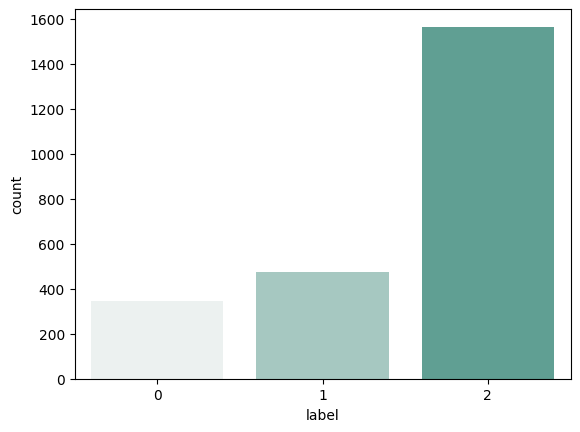

In [61]:
sns.countplot(data=val_data, x='label', palette='light:#5A9')

In [62]:
# Step-1 : Converting Sentences into tokens
val_data['tokens'] = val_data['text'].apply(preprocess)

In [63]:
print(val_data)

                                                   text  label  \
0     $ALLY - Ally Financial pulls outlook https://t...      0   
1     $DELL $HPE - Dell, HPE targets trimmed on comp...      0   
2     $PRTY - Moody's turns negative on Party City h...      0   
3                      $SAN: Deutsche Bank cuts to Hold      0   
4                     $SITC: Compass Point cuts to Sell      0   
...                                                 ...    ...   
2383  Stocks making the biggest moves midday: TD Ame...      2   
2384  Stocks making the biggest moves premarket: Fit...      2   
2385  Stocks making the biggest moves premarket: Hom...      2   
2386  Stocks making the biggest moves premarket: TD ...      2   
2387         TCO, NNVC, GPOR and JE among midday movers      2   

                                                 tokens  
0                    [, ally, financial, pull, outlook]  
1        [, dell, hpe, target, trim, compute, headwind]  
2             [, moody, s, turn, 

In [127]:
# TF-IDF Vectorization
val_data['processed_text'] = val_data['tokens'].apply(lambda x: ' '.join(x))
tfidf_vectorizer = TfidfVectorizer(max_features=total_words_less_than_n)  # Choose the maximum number of features
X_val = tfidf_vectorizer.fit_transform(val_data['processed_text']).toarray()
y_val = val_data['label']

In [128]:
X_val = X_val.tolist()
y_val = y_val.tolist()


In [129]:
# Predicting with the best model
y_pred_val = best_model.predict(X_val)

In [130]:
# Accuracy of the best model
# Model evaluation
val_accuracy = accuracy_score(y_val, y_pred_val)
print(f"Accuracy: {val_accuracy:.2f}")
print("classification_report:")
print("```")
print(classification_report(y_val, y_pred_val))
print("```")
print("Confusion Matrix:")
print("```")
print(confusion_matrix(y_val, y_pred_val))
print("```")

Accuracy: 0.53
classification_report:
```
              precision    recall  f1-score   support

           0       0.19      0.23      0.21       347
           1       0.22      0.14      0.17       475
           2       0.67      0.71      0.69      1566

    accuracy                           0.53      2388
   macro avg       0.36      0.36      0.35      2388
weighted avg       0.51      0.53      0.52      2388

```
Confusion Matrix:
```
[[  80   49  218]
 [  81   66  328]
 [ 268  188 1110]]
```


In [ ]:
# Saving the model
# save the model to disk
filename = 'finalized_model.pickle'
pickle.dump(best_model, open(filename, 'wb'))